# Final Project Forecasting

Course: Predictive Modelling Analytics

Group Member:
- xxx
- xxx
- xxx


## Setup
### Initialize Global Variables

In [770]:
WINDOW_SIZE = 12 # 12 months (1 year)
FORECAST_WINDOW = 12 # 1 years
ARRIVAL = 'Kedatangan_Internasional'

### Import Libraries, Dependencides and Dataset

In [771]:
# Importing the libraries
# %pip install pmdarima tensorflow

import pandas as pd
from pandas import read_csv
from pandas import to_datetime
from pandas.plotting import autocorrelation_plot

import seaborn as sn

import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error 
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.metrics import MeanAbsolutePercentageError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Dense

import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, YearLocator, MonthLocator


import statsmodels.api as sm
from pmdarima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


# import warnings
# warnings.filterwarnings('ignore')

# Importing the dataset
data = read_csv("Dataset/Data_FP_PAP-C.csv")
data.head()

,Tahun,Bulan,Kedatangan_Internasional,Periode,Tanggal
0,2017,1,9394,1,01/01/2017
1,2017,2,8775,2,02/01/2017
2,2017,3,11305,3,03/01/2017
3,2017,4,13204,4,04/01/2017
4,2017,5,11792,5,05/01/2017


## Preprocessing

In [772]:
#Checking for missing values
data.isnull().sum()

Tahun                       0
Bulan                       0
Kedatangan_Internasional    0
Periode                     0
Tanggal                     0
dtype: int64

In [773]:
# Check NaN values
data.isnull().sum() 

Tahun                       0
Bulan                       0
Kedatangan_Internasional    0
Periode                     0
Tanggal                     0
dtype: int64

In [774]:
# Check null values
data.isna().sum()

Tahun                       0
Bulan                       0
Kedatangan_Internasional    0
Periode                     0
Tanggal                     0
dtype: int64

In [775]:
# Data Description
data.describe()

,Tahun,Bulan,Kedatangan_Internasional,Periode
count,94.000000,94.000000,94.000000,94.000000
mean,2020.425532,6.393617,4432.276596,46.223404
std,2.269429,3.427335,3815.606011,25.487570
min,2017.000000,1.000000,0.000000,1.000000
25%,2018.250000,3.250000,141.250000,24.250000
50%,2020.000000,6.000000,4266.000000,47.500000
75%,2022.000000,9.000000,7100.000000,70.750000
max,2024.000000,12.000000,13980.000000,84.000000


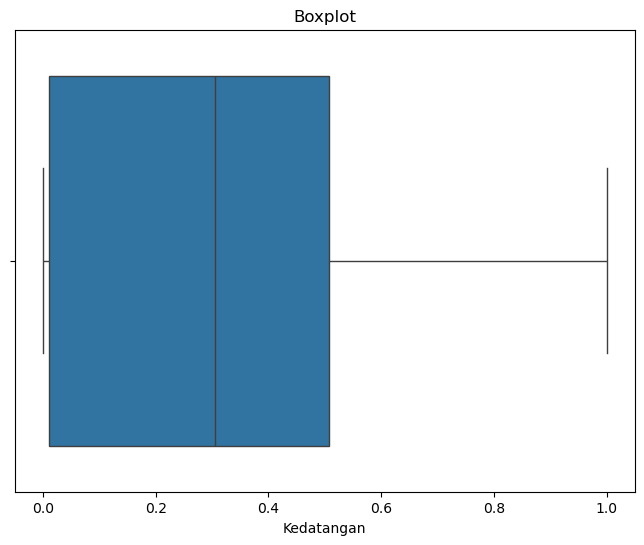

In [776]:
# Boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x=new_df['Kedatangan_Internasional'])
plt.title('Boxplot')
plt.xlabel('Kedatangan')
plt.show()

In [777]:
curr = pd.to_datetime(data.iloc[-1]['Tanggal']).strftime('%m/%d/%Y').split('/')
index = []
for i in range(12):
    m = int(curr[0])
    y = int(curr[2])
    if m < 12:
        curr[0] = str(m+1)
    else:
        curr[2] = str(y+1)
        curr[0] = str(1)
    idx = "/".join(curr)
    index.append(idx)
index_forecast = to_datetime(pd.Series(index))
index_forecast

0    2024-11-01
1    2024-12-01
2    2025-01-01
3    2025-02-01
4    2025-03-01
5    2025-04-01
6    2025-05-01
7    2025-06-01
8    2025-07-01
9    2025-08-01
10   2025-09-01
11   2025-10-01
dtype: datetime64[ns]

In [778]:
data['Tanggal'] = to_datetime(data['Tanggal'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Tahun                     94 non-null     int64         
 1   Bulan                     94 non-null     int64         
 2   Kedatangan_Internasional  94 non-null     int64         
 3   Periode                   94 non-null     int64         
 4   Tanggal                   94 non-null     datetime64[ns]
dtypes: datetime64[ns](1), int64(4)
memory usage: 3.8 KB


## Exploratory Data Analysis (EDA)

### Visualization

In [779]:
import matplotlib.pyplot as plt

def compare_pred_actual(results, title):
 
    fig, ax = plt.subplots(figsize=(12, 8))
    fig.tight_layout(pad=5.0)

    # Plot predictions and actuals for each scenario
    for scenario, result in results.items():
        ax.plot(result['Tanggal'], result['Predictions'], label=f'{scenario} Predictions', linestyle='--')
        ax.plot(result['Tanggal'], result['Actuals'], label=f'{scenario} Actuals', alpha=0.7)

    plt.xlim([min(result['Tanggal']), max(result['Tanggal'])])

    ax.xaxis.set_major_locator(YearLocator())
    ax.xaxis.set_minor_locator(MonthLocator((4,8,12)))
    ax.xaxis.set_major_formatter(DateFormatter("\n%Y"))
    ax.xaxis.set_minor_formatter(DateFormatter("%b"))
    plt.setp(ax.get_xticklabels(), rotation=0, ha="center")
    
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Values', fontsize=12)
    ax.get_yaxis().get_major_formatter().set_scientific(False)
    ax.legend(loc='best')

    # Improve the x-axis formatting for dates
    ax.tick_params(axis='x', rotation=45)
    plt.show()


In [780]:
def visualize(data, var=[], label=''):
    fig, ax = plt.subplots(figsize=(25, 10))
    plt.title('Visualisasi Data', fontsize=20)

    for v in var:
        ax.plot(data['Tanggal'].iloc[0:], data[v].iloc[0:], label=v)
        
    plt.xlim([min(data['Tanggal']), max(data['Tanggal'])])
    plt.xlabel('Date', fontsize=15)

    ax.xaxis.set_major_locator(YearLocator())
    ax.xaxis.set_minor_locator(MonthLocator((4,8,12)))
    ax.xaxis.set_major_formatter(DateFormatter("\n%Y"))
    ax.xaxis.set_minor_formatter(DateFormatter("%b"))
    plt.setp(ax.get_xticklabels(), rotation=0, ha="center")
    ax.get_yaxis().get_major_formatter().set_scientific(False)


    plt.legend()
    plt.show()

In [781]:
data

,Tahun,Bulan,Kedatangan_Internasional,Periode,Tanggal
0,2017,1,9394,1,2017-01-01
1,2017,2,8775,2,2017-02-01
2,2017,3,11305,3,2017-03-01
3,2017,4,13204,4,2017-04-01
4,2017,5,11792,5,2017-05-01
...,...,...,...,...,...
89,2024,6,6893,78,2024-06-01
90,2024,7,8652,79,2024-07-01
91,2024,8,8122,80,2024-08-01
92,2024,9,7461,81,2024-09-01


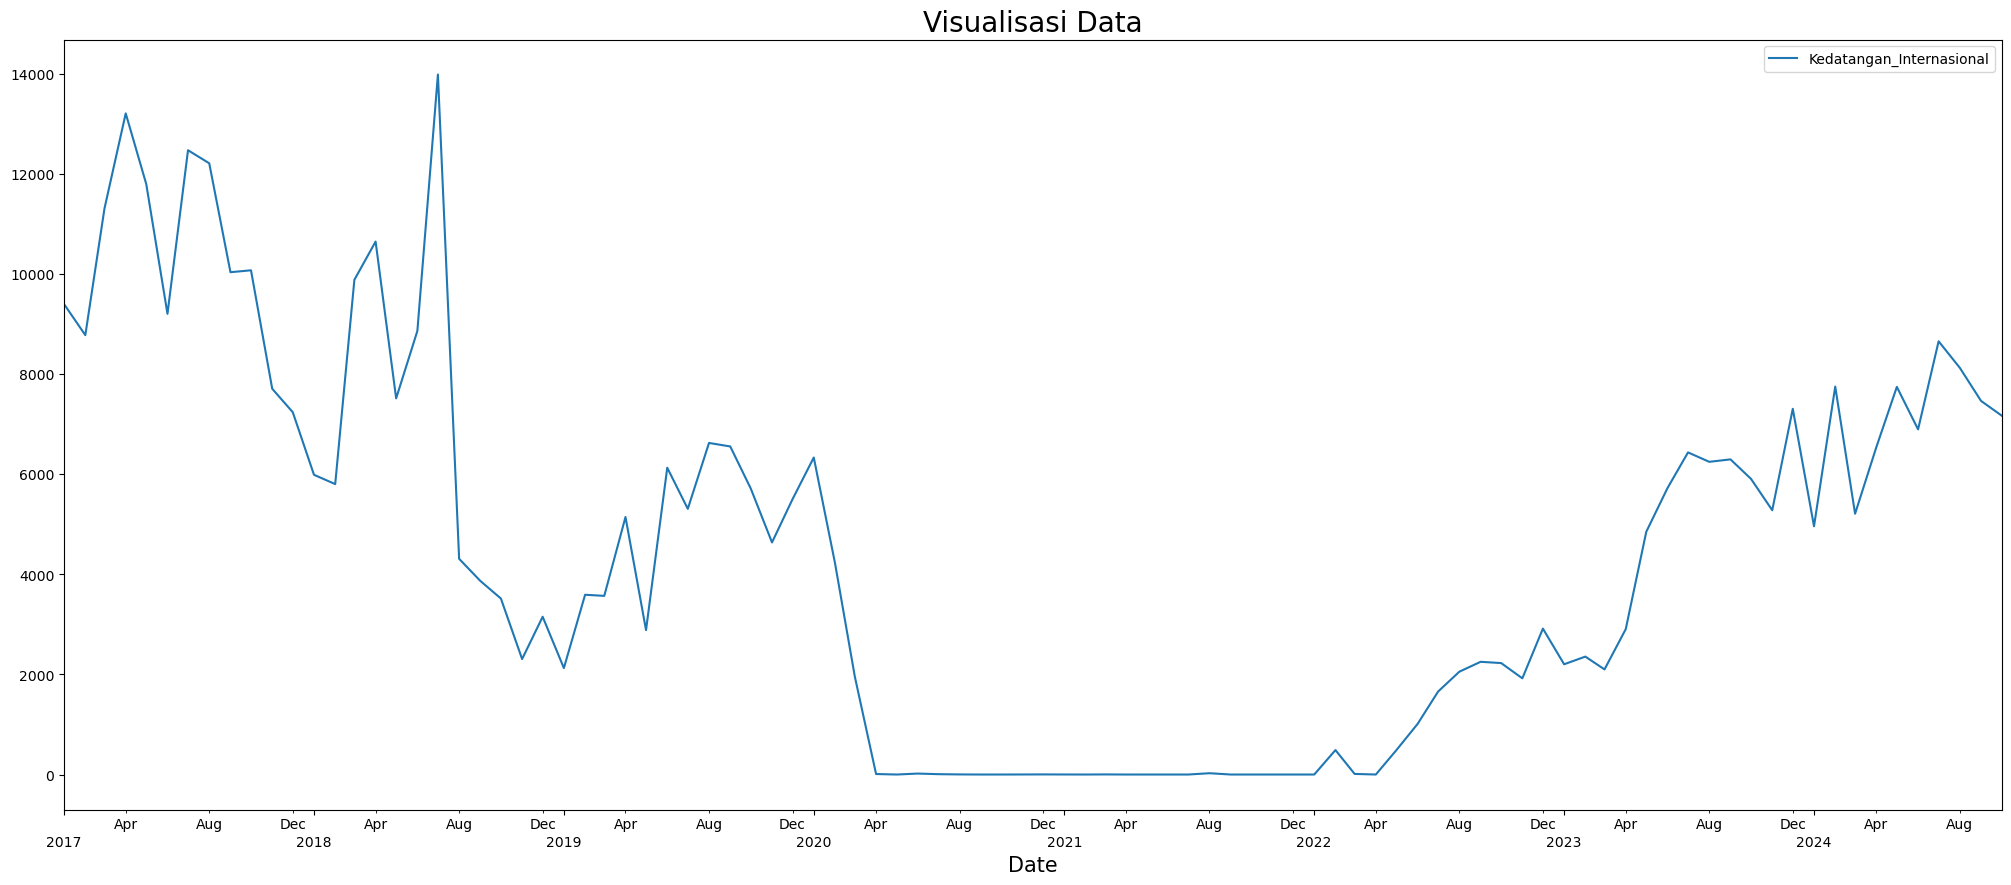

In [782]:
visualize(data, [ARRIVAL])

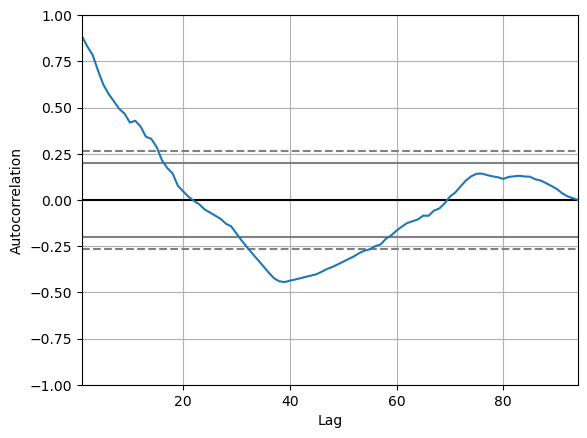

In [783]:


# Plot autocorrelation and partial autocorrelation
autocorrelation_plot(data[ARRIVAL])
plt.show()

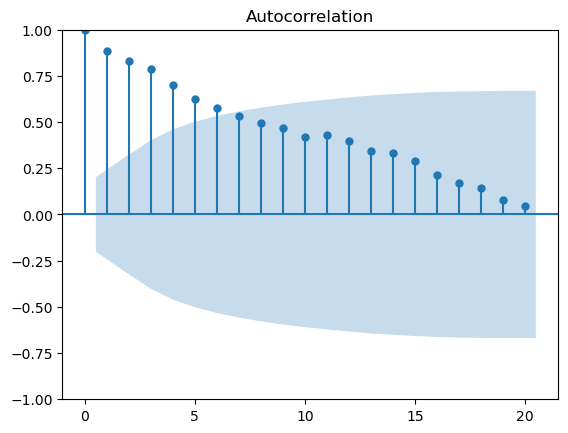

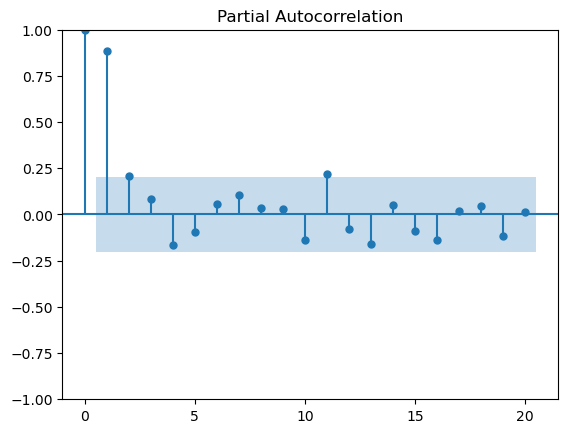

In [784]:
# Plot ACF dan PACF
plot_acf(data[ARRIVAL])
plot_pacf(data[ARRIVAL])
plt.show()

In [785]:
# Augmented Dickey-Fuller Test
def adf_test(data):
    result = adfuller(data, autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print(f'Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')

adf_test(data[ARRIVAL])

ADF Statistic: -1.8235632254380563
p-value: 0.3688275378364241
Critical Values:
	1%: -3.503514579651927
	5%: -2.893507960466837
	10%: -2.583823615311909


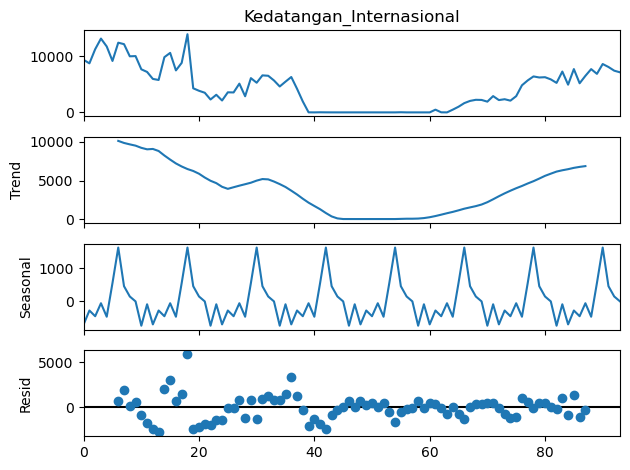

In [786]:
# Decompose time series data using the additive model
decomposition = seasonal_decompose(data[ARRIVAL], model='additive', period=12)  # Assuming a seasonal period of 12 (monthly)
decomposition.plot()
plt.show()

## Modeling
### Data Windows

In [787]:
def dataframe_to_windowed_data(df, window_size):
  df_as_np = df.to_numpy()
  x = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    x.append(row)
    label = df_as_np[i+window_size]

    y.append(label)
  return np.array(x), np.array(y)

### Building Models
#### Prophet


#### SARIMA

In [816]:
# Convert 'Tanggal' to datetime and set as index
data['Tanggal'] = pd.to_datetime(data['Tanggal'], format='%d/%m/%Y')
data.set_index('Tanggal', inplace=True)

In [817]:
data

,Tahun,Bulan,Kedatangan_Internasional,Periode
Tanggal,,,,
2017-01-01,2017,1,9394,1
2017-02-01,2017,2,8775,2
2017-03-01,2017,3,11305,3
2017-04-01,2017,4,13204,4
2017-05-01,2017,5,11792,5
...,...,...,...,...
2024-06-01,2024,6,6893,78
2024-07-01,2024,7,8652,79
2024-08-01,2024,8,8122,80


In [818]:
def train_ARIMA(train_ratio=0.8, order=(2, 1, 1), seasonal_order=(1, 1, 1, 12)):
	"""
	Create and train a SARIMA model and return predictions for both train and test sets.
	"""
	# Step 1: Split data into train and test sets
	train_size = int(len(data) * train_ratio)
	train, test = data.iloc[:train_size], data.iloc[train_size:]

	# Step 2: Fit the SARIMA model
	sarima_model = SARIMAX(
		train[ARRIVAL],
		order=order,
		seasonal_order=seasonal_order
	)
	sarima_fit = sarima_model.fit(disp=False)

	# Step 3: Generate SARIMA predictions for train and test sets
	train_predictions = sarima_fit.predict(start=train.index[0], end=train.index[-1])
	SARIMA_forecast = sarima_fit.get_forecast(steps=len(test))
	test_predictions = SARIMA_forecast.predicted_mean

	# Combine results
	train_results = pd.DataFrame({'Tanggal': train['Tanggal'], 'Actuals': train[ARRIVAL], 'Predictions': train_predictions})
	test_results = pd.DataFrame({'Tanggal': test['Tanggal'], 'Actuals': test[ARRIVAL], 'Predictions': test_predictions})

	return train_results, test_results

def forecast_ARIMA(order=(2, 1, 1), seasonal_order=(1, 1, 1, 12)):
	"""
	Create and train a SARIMA model and return predictions for both train and test sets.
	"""
	# Step 1: Fit the SARIMA model
	sarima_model = SARIMAX(
		data[ARRIVAL],
		order=order,
		seasonal_order=seasonal_order
	)
	sarima_fit = sarima_model.fit(disp=False)

	# Step 2: Generate SARIMA predictions for train and test sets
	SARIMA_forecast = sarima_fit.get_forecast(steps=FORECAST_WINDOW)
	forecast_predictions = SARIMA_forecast.predicted_mean

	# Combine results
	forecast_results = pd.DataFrame({'Predictions': forecast_predictions})

	return forecast_results
	


#### LSTM

In [789]:
def create_LSTM() -> Sequential:
    model_LSTM = Sequential()
    model_LSTM.add(LSTM(64, activation='relu', input_shape=(WINDOW_SIZE, 1), return_sequences=True))
    model_LSTM.add(Dropout(0.2))
    model_LSTM.add(LSTM(64, activation='relu'))
    model_LSTM.add(Dropout(0.2))
    model_LSTM.add(Dense(8, activation='relu'))
    model_LSTM.add(Dense(1, activation='linear'))
    model_LSTM.compile(optimizer='adam', loss='mse')
    return model_LSTM

def train_LSTM(train_ratio=0.8) -> dict:
    train_res = {}
    test_res = {}

    x, y = dataframe_to_windowed_data(data[ARRIVAL], WINDOW_SIZE)
    range_index_train = int(train_ratio * len(x))

    x_train, y_train = x[:range_index_train], y[:range_index_train]
    x_test, y_test = x[range_index_train:], y[range_index_train:]

    model_LSTM = create_LSTM()
    model_LSTM.fit(x_train, y_train, epochs=100, batch_size=2)

    train_predictions = model_LSTM.predict(x_train).flatten()
    train_results = pd.DataFrame(data={'Tanggal': data['Tanggal'][WINDOW_SIZE:range_index_train+WINDOW_SIZE], 'Predictions': train_predictions, 'Actuals': y_train})
    train_res[ARRIVAL] = train_results

    predictions_LSTM = model_LSTM.predict(x_test).flatten()
    test_results = pd.DataFrame(data={'Tanggal': data['Tanggal'][range_index_train+WINDOW_SIZE:], 'Predictions': predictions_LSTM, 'Actuals': y_test})
    test_res[ARRIVAL] = test_results

    return train_res, test_res

def forecast_LSTM(forecast_window):
    results = {}

    model = create_LSTM()
    x, y = dataframe_to_windowed_data(data[ARRIVAL], WINDOW_SIZE)
    model.fit(x, y, epochs=100, batch_size=2)
    
    forecast = []
    current_input = y[-WINDOW_SIZE:].reshape((1, WINDOW_SIZE, 1))
    
    for _ in range(forecast_window):
        next_pred = model.predict(current_input)[0, 0]
        forecast.append(next_pred)
        current_input = np.append(current_input[:, 1:, :], [[[next_pred]]], axis=1)
    
    forecast = pd.Series(forecast, index=index_forecast)
    results[ARRIVAL] = forecast
    
    return results


#### HYBRID (SARIMA-LSTM)

In [790]:
# 
def create_SARIMA_LSTM(data, arrival_column, train_ratio=0.8, window_size=12, epochs=100, batch_size=2):
    """
    Create Hybrid SARIMA-LSTM model:
    1. Train SARIMA to capture linear trends.
    2. Train LSTM to capture residual non-linear trends.
    """
    # Split data into train and test
    train_size = int(len(data) * train_ratio)
    train, test = data.iloc[:train_size], data.iloc[train_size:]

    # Step 1: Train SARIMA
    sarima_model = SARIMAX(
        train[arrival_column],
        order=(2, 1, 1),               # ARIMA parameters
        seasonal_order=(1, 1, 1, 12),  # Seasonal parameters
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    sarima_fit = sarima_model.fit(disp=False)

    # SARIMA Predictions
    sarima_train_predictions = sarima_fit.predict(start=train.index[0], end=train.index[-1])
    sarima_forecast = sarima_fit.get_forecast(steps=len(test))
    sarima_test_predictions = sarima_forecast.predicted_mean

    # Residuals for LSTM
    train_residuals = train[arrival_column] - sarima_train_predictions

    # Step 2: Train LSTM on Residuals
    def create_windowed_data(series, window_size):
        x, y = [], []
        for i in range(len(series) - window_size):
            x.append(series[i:i + window_size])
            y.append(series[i + window_size])
        return np.array(x), np.array(y)

    # Scale residuals
    residuals_scaled = (train_residuals - train_residuals.min()) / (train_residuals.max() - train_residuals.min())
    x, y = create_windowed_data(residuals_scaled.values, window_size)

    # Train-test split for LSTM
    split_idx = len(x) - len(test)  # Align LSTM residuals with test size
    x_train, y_train = x[:split_idx], y[:split_idx]
    x_test, y_test = x[split_idx:], y[split_idx:]

    # Create and Train LSTM
    lstm_model = Sequential()
    lstm_model.add(LSTM(64, activation='relu', input_shape=(window_size, 1), return_sequences=True))
    lstm_model.add(Dropout(0.2))
    lstm_model.add(LSTM(64, activation='relu'))
    lstm_model.add(Dropout(0.2))
    lstm_model.add(Dense(8, activation='relu'))
    lstm_model.add(Dense(1, activation='linear'))
    lstm_model.compile(optimizer='adam', loss='mse')
    lstm_model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

    # LSTM Predictions (on residuals)
    lstm_train_predictions = lstm_model.predict(x_train).flatten()
    lstm_test_predictions = lstm_model.predict(x_test).flatten()

    # Reverse scaling
    lstm_train_predictions = lstm_train_predictions * (train_residuals.max() - train_residuals.min()) + train_residuals.min()
    lstm_test_predictions = lstm_test_predictions * (train_residuals.max() - train_residuals.min()) + train_residuals.min()

    # Step 3: Combine SARIMA and LSTM Predictions
    aligned_train = train.iloc[window_size:]  # Align train data with LSTM window
    sarima_train_predictions_aligned = sarima_train_predictions[window_size:]  # Align SARIMA with LSTM

    hybrid_train_predictions = sarima_train_predictions_aligned[:len(lstm_train_predictions)].values + lstm_train_predictions
    hybrid_test_predictions = sarima_test_predictions.values[:len(lstm_test_predictions)] + lstm_test_predictions

    # Align `aligned_train` with `hybrid_train_predictions`
    aligned_train = aligned_train.iloc[-len(hybrid_train_predictions):]

    # Combine Actuals
    train_results = pd.DataFrame({
        'Tanggal': aligned_train['Tanggal'],
        'Actuals': aligned_train[arrival_column],
        'Predictions': hybrid_train_predictions
    })
    test_results = pd.DataFrame({
        'Tanggal': test['Tanggal'][:len(hybrid_test_predictions)],
        'Actuals': test[arrival_column][:len(hybrid_test_predictions)],
        'Predictions': hybrid_test_predictions 
    })



    return train_results, test_results

def forecast_SARIMA_LSTM(data, arrival_column, forecast_window, window_size=12, epochs=100, batch_size=2):
    """
    Forecast using Hybrid SARIMA-LSTM model.
    """
    # Step 1: Train SARIMA
    sarima_model = SARIMAX(
        data[arrival_column],
        order=(2, 1, 1),               # ARIMA parameters
        seasonal_order=(1, 1, 1, 12),  # Seasonal parameters
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    sarima_fit = sarima_model.fit(disp=False)

    # SARIMA Predictions
    sarima_forecast = sarima_fit.get_forecast(steps=forecast_window)
    sarima_predictions = sarima_forecast.predicted_mean

    # Step 2: Train LSTM on Residuals
    residuals = data[arrival_column] - sarima_fit.fittedvalues

    # Scale residuals
    residuals_scaled = (residuals - residuals.min()) / (residuals.max() - residuals.min())

    # Create windowed data
    x, y = dataframe_to_windowed_data(residuals_scaled, window_size)

    # Train LSTM
    lstm_model = create_LSTM()
    lstm_model.fit(x, y, epochs=epochs, batch_size=batch_size, verbose=1)

    # Forecast LSTM
    forecast = []
    current_input = residuals_scaled[-window_size:].values.reshape((1, window_size, 1))

    for _ in range(forecast_window):
        next_pred = lstm_model.predict(current_input)[0, 0]
        forecast.append(next_pred)

        # Update input
        current_input = np.append(current_input[:, 1:, :], [[[next_pred]]], axis=1)

    # Reverse scaling
    forecast = np.array(forecast) * (residuals.max() - residuals.min()) + residuals.min()

    # Combine SARIMA and LSTM forecasts
    forecast_results = pd.DataFrame({
        'Tanggal': index_forecast,
        'Predictions': sarima_predictions + forecast
    })

    return forecast_SARIMA_LSTM

## Training and Testing

1. 80% Train - 20% Test
2. 70% Train - 30 % Test
3. 60% Train - 40 % Test


## Evaluation


In [791]:
SARIMA_train_results_80, _ = train_ARIMA(0.8)
SARIMA_train_results_80

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,Tanggal,Actuals,Predictions
0,2017-01-01,9394,0.000000
1,2017-02-01,8775,7745.156774
2,2017-03-01,11305,7967.107743
3,2017-04-01,13204,11011.692140
4,2017-05-01,11792,12476.227638
...,...,...,...
70,2022-11-01,1921,1453.641781
71,2022-12-01,2914,1937.469079
72,2023-01-01,2202,3311.576373
73,2023-02-01,2355,2459.193467


### Prophet

### SARIMA

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


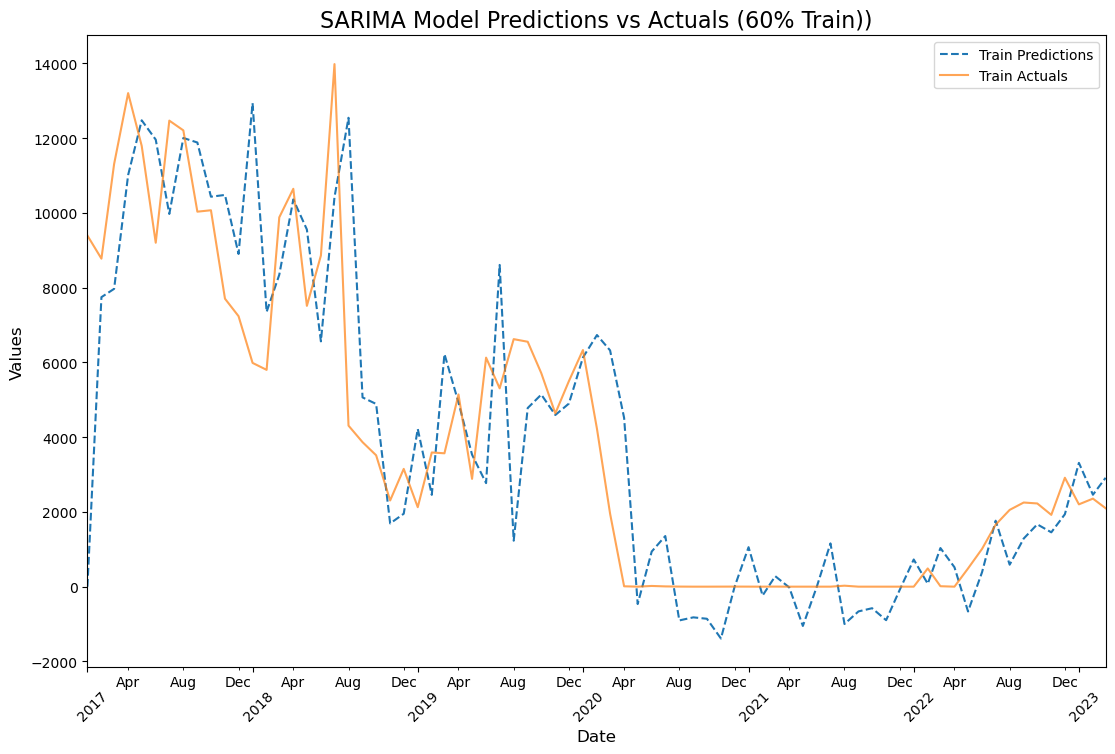

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


ARIMA Model Evaluation Metrics (80% Train):
MSE: 5591991.899135302
MAE: 1569.915643683268
MAPE: inf
R²: 0.658489209809147


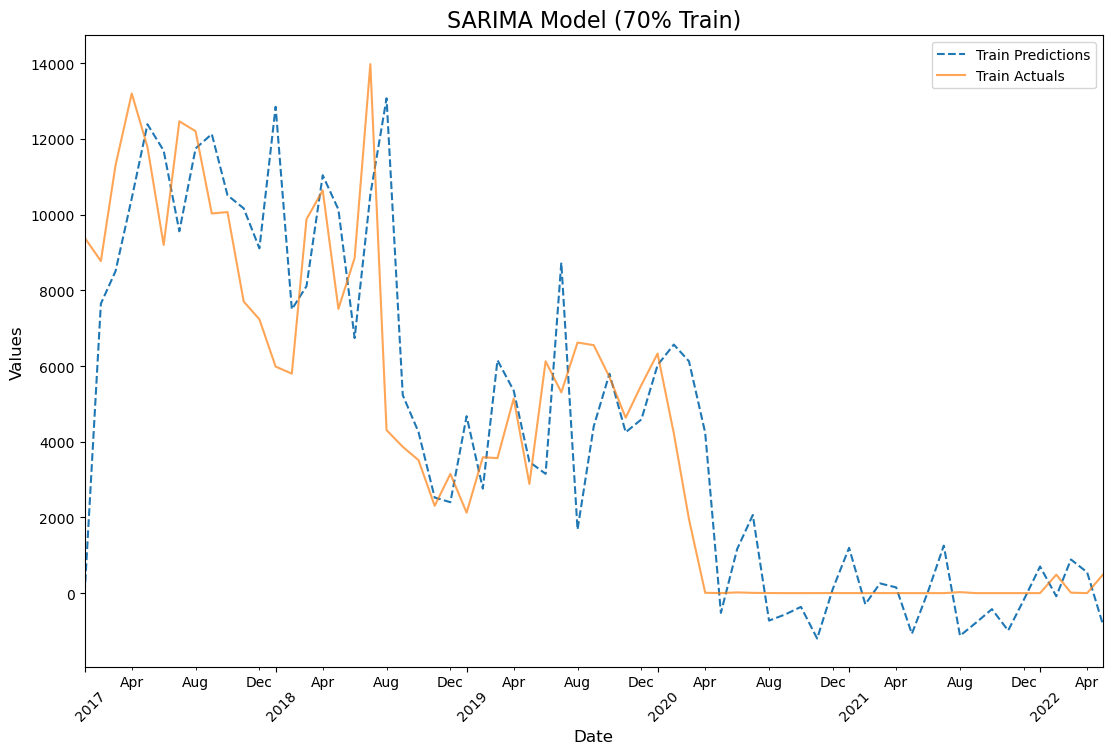

ARIMA Model Evaluation Metrics (70% Train):
MSE: 6400175.335204091
MAE: 1713.3276138890508
MAPE: inf
R²: 0.6491322227814318


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


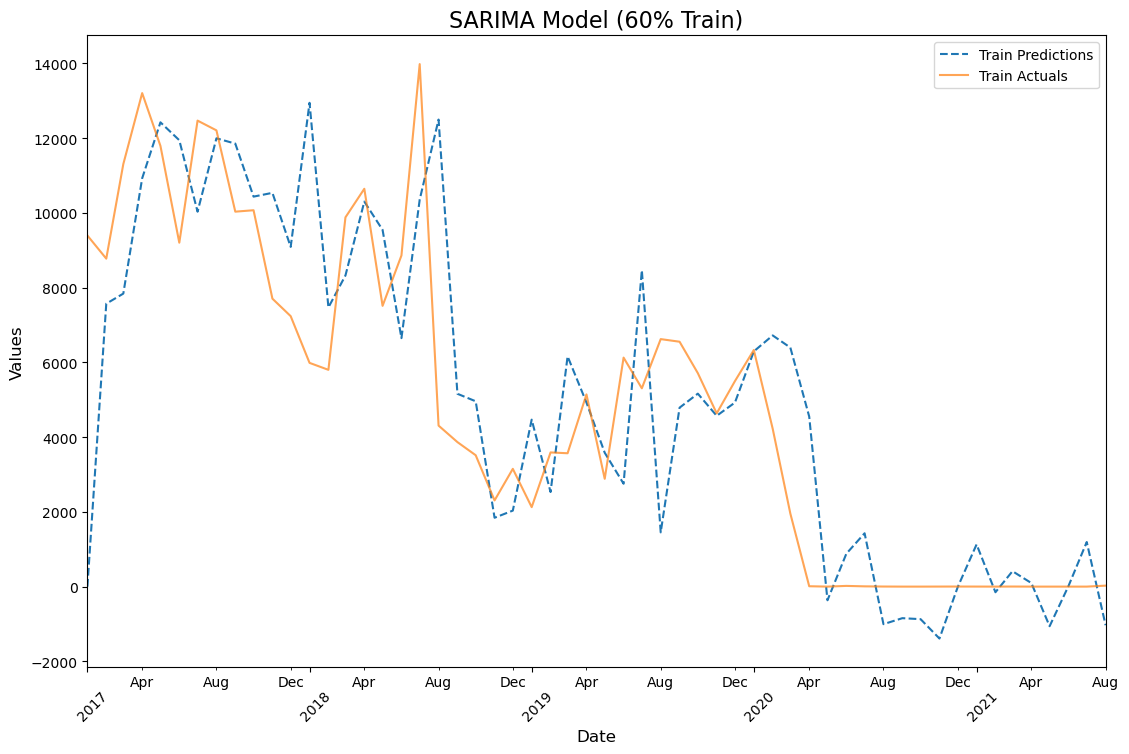

ARIMA Model Evaluation Metrics (60% Train):
MSE: 7296312.265315372
MAE: 1876.8146562784584
MAPE: inf
R²: 0.594854412917434


In [792]:
# Scenario 1: 80% Train - 20% Test
SARIMA_train_results_80, _ = train_ARIMA(0.8)
compare_pred_actual({'Train': SARIMA_train_results_80}, 'SARIMA Model Predictions vs Actuals (60% Train))')

# Evaluate the ARIMA model by using MSE, MAPE, MAE, and R² metrics
mse, mae, mape, r2 = evaluate_model(SARIMA_train_results_80['Actuals'], SARIMA_train_results_80['Predictions'])
print(f"ARIMA Model Evaluation Metrics (80% Train):")
print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}")
print(f"R²: {r2}")

# Scenario 2: 70% Train - 30% Test
SARIMA_train_results_70, _ = train_ARIMA(0.7)
compare_pred_actual({'Train': SARIMA_train_results_70}, 'SARIMA Model (70% Train)')

# Evaluate the ARIMA model by using MSE, MAPE, MAE, and R² metrics
mse, mae, mape, r2 = evaluate_model(SARIMA_train_results_70['Actuals'], SARIMA_train_results_70['Predictions'])
print(f"ARIMA Model Evaluation Metrics (70% Train):")
print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}")
print(f"R²: {r2}")

# Scenario 3: 60% Train - 40% Test
SARIMA_train_results_60, _ = train_ARIMA(0.6)
compare_pred_actual({'Train': SARIMA_train_results_60}, 'SARIMA Model (60% Train)')

# Evaluate the ARIMA model by using MSE, MAPE, MAE, and R² metrics
mse, mae, mape, r2 = evaluate_model(SARIMA_train_results_60['Actuals'], SARIMA_train_results_60['Predictions'])
print(f"ARIMA Model Evaluation Metrics (60% Train):")
print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}")
print(f"R²: {r2}")

### LSTM

/Users/ajhiswara/.local/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 13491967.0000
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10245372.0000
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6725292.5000
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8238578.5000 
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8536950.0000
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6214935.5000
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5568327.5000
Epoch 8/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6520636.0000
Epoch 9/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8005991.0000
Epoch 10/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7307385.0000
Epoch 11/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5724451.0000
Epoch 12/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6963531.5000
Epoch 13/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8564901.0000
Epoch 14/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - los

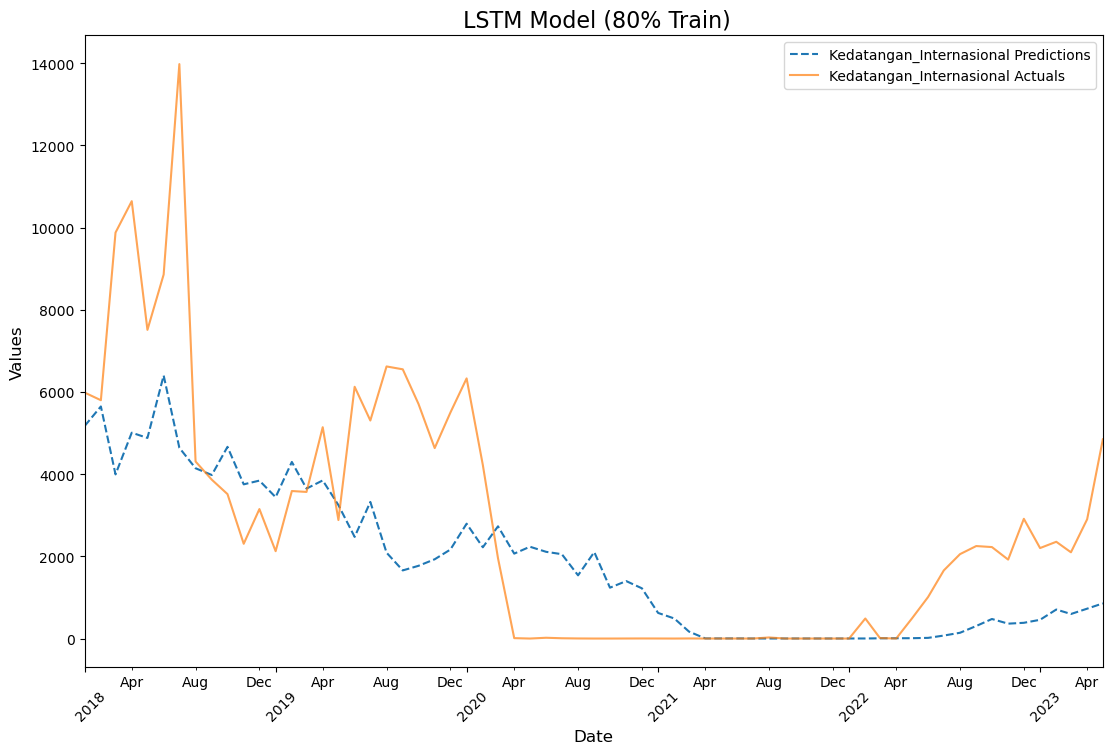

LSTM Model Evaluation Metrics:
MSE: 0.011992005534626237
MAE: 0.09131867520975843
MAPE: 39.76324452030369
R²: -1.3971020434085935
Epoch 1/100


/Users/ajhiswara/.local/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 10419360.0000
Epoch 2/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6472360.5000
Epoch 3/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4203722.0000
Epoch 4/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9156548.0000 
Epoch 5/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5672508.0000
Epoch 6/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12362690.0000
Epoch 7/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6817897.5000
Epoch 8/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8214210.5000
Epoch 9/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6031538.5000 
Epoch 10/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4513293.5000
Epoch 11/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6814249.0000
Epoch 12/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3581937.7500
Epoch 13/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16984230.0000
Epoch 14/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1179103

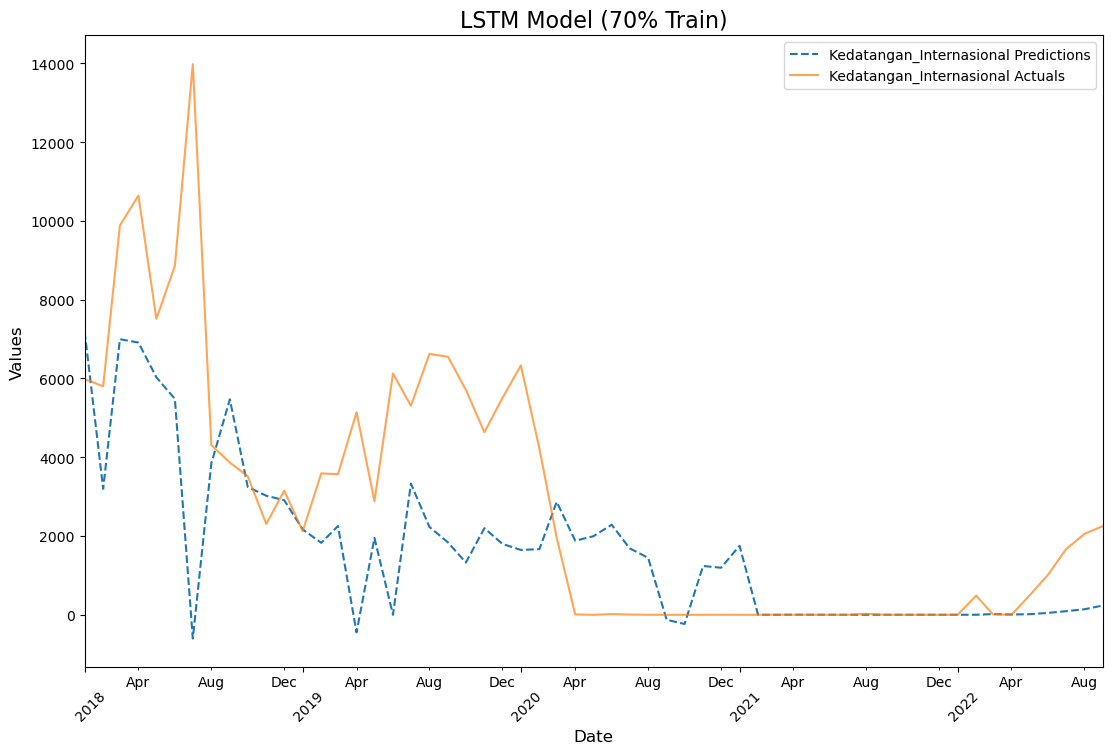

LSTM Model Evaluation Metrics:
MSE: 0.011992005534626237
MAE: 0.09131867520975843
MAPE: 39.76324452030369
R²: -1.3971020434085935
Epoch 1/100


/Users/ajhiswara/.local/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 24291870.0000
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8272771.5000
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14011100.0000
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10821880.0000
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10436310.0000
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8521782.0000
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7757149.5000
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9619067.0000 
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8579444.0000
Epoch 10/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9171273.0000 
Epoch 11/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6070042.0000
Epoch 12/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9371815.0000 
Epoch 13/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8393097.0000 
Epoch 14/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6029

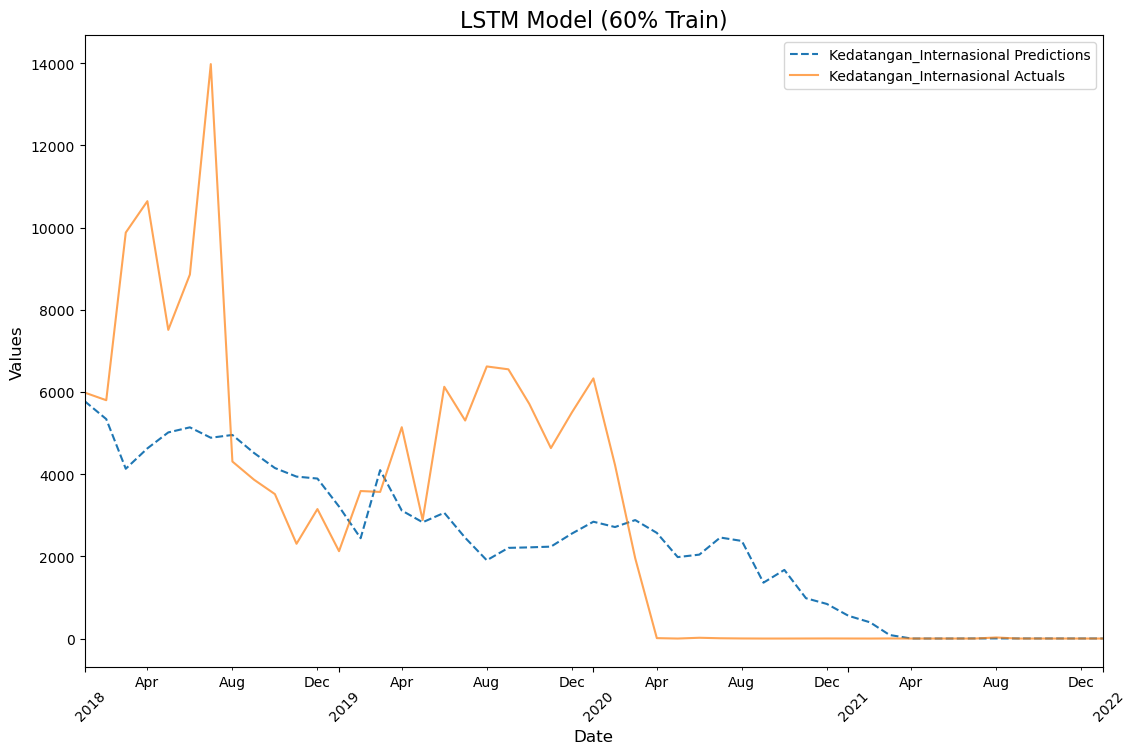

LSTM Model Evaluation Metrics:
MSE: 0.011992005534626237
MAE: 0.09131867520975843
MAPE: 39.76324452030369
R²: -1.3971020434085935


In [793]:
# Scenario 1: 80% Train - 20% Test
LSTM_train_results_80, LSTM_test_results_80 = train_LSTM(0.8)
compare_pred_actual(LSTM_train_results_80, title=" LSTM Model (80% Train)")

# Evaluate the LSTM model by using MSE, MAPE, MAE, and R² metrics
mse, mae, mape, r2 = evaluate_model(LSTM_test_results[ARRIVAL]['Actuals'], LSTM_test_results[ARRIVAL]['Predictions'])
print(f"LSTM Model Evaluation Metrics:")
print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}")
print(f"R²: {r2}")

# Scenario 1: 70% Train - 30% Test
LSTM_train_results_70, LSTM_test_results_70 = train_LSTM(0.7)
compare_pred_actual(LSTM_train_results_70, title="LSTM Model (70% Train)")

# Evaluate the LSTM model by using MSE, MAPE, MAE, and R² metrics
mse, mae, mape, r2 = evaluate_model(LSTM_test_results[ARRIVAL]['Actuals'], LSTM_test_results[ARRIVAL]['Predictions'])
print(f"LSTM Model Evaluation Metrics:")
print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}")
print(f"R²: {r2}")

# Scenario 1: 60% Train - 40% Test
LSTM_train_results_60, LSTM_test_results_60 = train_LSTM(0.6)
compare_pred_actual(LSTM_train_results_60, title="LSTM Model (60% Train)")

# Evaluate the LSTM model by using MSE, MAPE, MAE, and R² metrics
mse, mae, mape, r2 = evaluate_model(LSTM_test_results[ARRIVAL]['Actuals'], LSTM_test_results[ARRIVAL]['Predictions'])
print(f"LSTM Model Evaluation Metrics:")
print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}")
print(f"R²: {r2}")



### HYBRID (SARIMA-LSTM)

Epoch 1/100


/Users/ajhiswara/.local/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1583   
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0161
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0165
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0246
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0221
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0300 
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0251
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0243
Epoch 9/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0250
Epoch 10/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0216
Epoch 11/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0281
Epoch 12/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0253
Epoch 13/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0213
Epoch 14/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0322
Epoch 15/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0235
Epoch 16/100

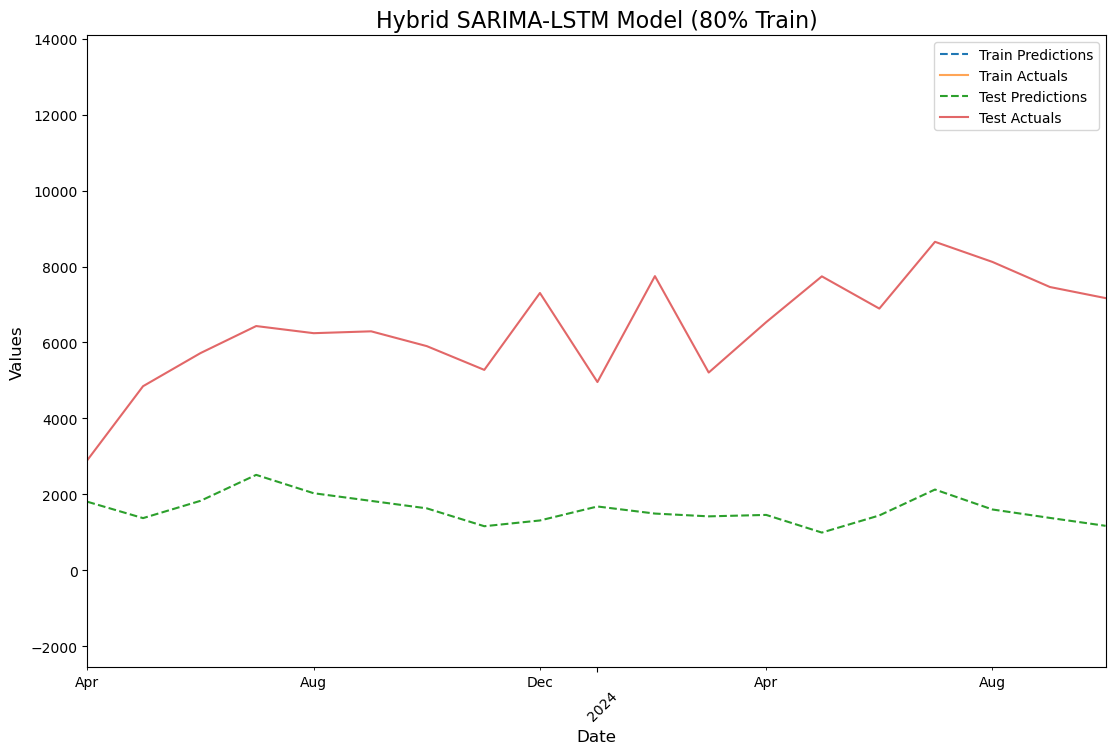

Hybrid Model Evaluation Metrics (80% Train):
MSE: 25056077.939536314
MAE: 4799.193856439889
MAPE: 73.3652992772778
R²: -12.763411357570014
Epoch 1/100


/Users/ajhiswara/.local/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2247   
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0823 
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0377 
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0374 
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0362 
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0252 
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0296
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0387 
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0318 
Epoch 10/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0333 
Epoch 11/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0544 
Epoch 12/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0296 
Epoch 13/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0260 
Epoch 14/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0562 
Epoch 15/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0464 


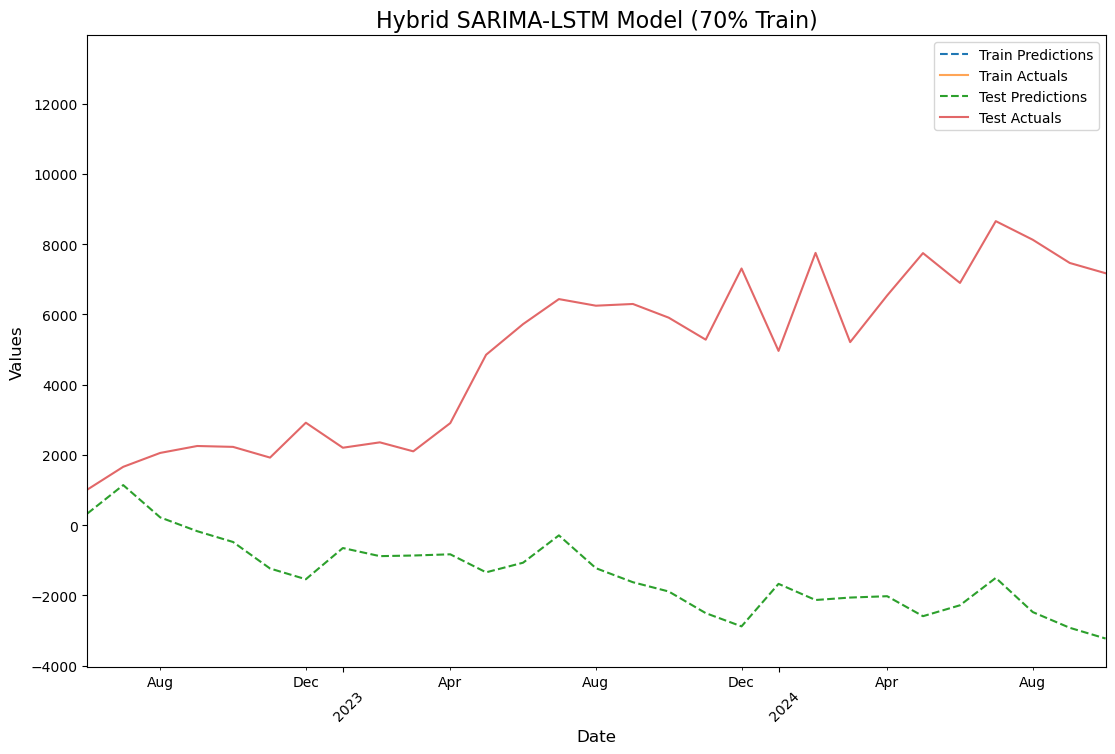

Hybrid Model Evaluation Metrics (70% Train):
MSE: 50077628.34738633
MAE: 6305.01098172312
MAPE: 124.76255861813056
R²: -8.126740254005536
Epoch 1/100


/Users/ajhiswara/.local/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2113  
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2076 
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2215 
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1909 
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2090
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1669
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1388
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1163
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0982
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0882
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0465
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0382
Epoch 13/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0502
Epoch 14/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0424
Epoch 15/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0718
Epoch 16/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 

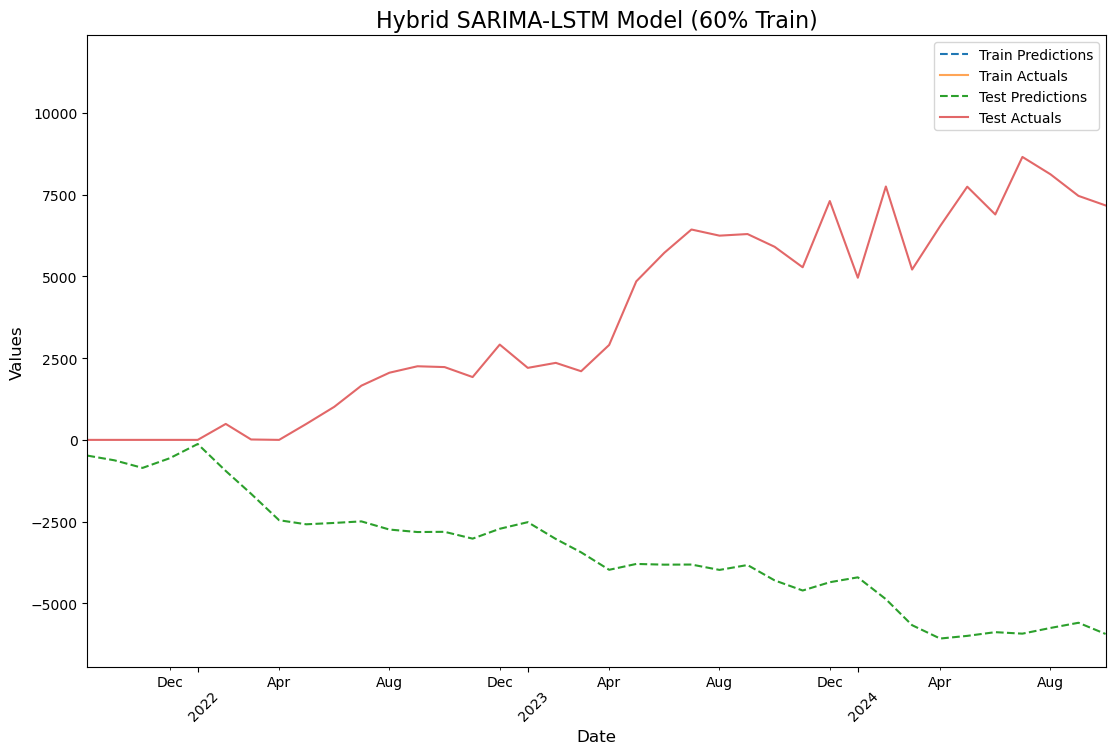

Hybrid Model Evaluation Metrics (60% Train):
MSE: 72254582.10995242
MAE: 7206.775241020182
MAPE: inf
R²: -7.6580989468903535


In [794]:
# Scenario 1: 80% Train - 20% Test
HYBRID_train_results_80, HYBRID_test_results_80 = create_SARIMA_LSTM(
    data=data, arrival_column=ARRIVAL, train_ratio=0.8
)
compare_pred_actual({'Train': HYBRID_train_results_80, 'Test': HYBRID_test_results_80}, 'Hybrid SARIMA-LSTM Model (80% Train)')
# Evaluate the Hybrid model by using MSE, MAPE, MAE, and R² metrics
mse, mae, mape, r2 = evaluate_model(HYBRID_test_results_80['Actuals'], HYBRID_test_results_80['Predictions'])
print(f"Hybrid Model Evaluation Metrics (80% Train):")
print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}")
print(f"R²: {r2}")

# Scenario 2: 70% Train - 30% Test
HYBRID_train_results_70, HYBRID_test_results_70 = create_SARIMA_LSTM(
    data=data, arrival_column=ARRIVAL, train_ratio=0.7
)
compare_pred_actual({'Train': HYBRID_train_results_70, 'Test': HYBRID_test_results_70}, 'Hybrid SARIMA-LSTM Model (70% Train)')
# Evaluate the Hybrid model by using MSE, MAPE, MAE, and R² metrics
mse, mae, mape, r2 = evaluate_model(HYBRID_test_results_70['Actuals'], HYBRID_test_results_70['Predictions'])
print(f"Hybrid Model Evaluation Metrics (70% Train):")
print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}")
print(f"R²: {r2}")

# Scenario 1: 60% Train - 40% Test
HYBRID_train_results_60, HYBRID_test_results_60 = create_SARIMA_LSTM(
    data=data, arrival_column=ARRIVAL, train_ratio=0.6
)
compare_pred_actual({'Train': HYBRID_train_results_60, 'Test': HYBRID_test_results_60}, 'Hybrid SARIMA-LSTM Model (60% Train)')
# Evaluate the Hybrid model by using MSE, MAPE, MAE, and R² metrics
mse, mae, mape, r2 = evaluate_model(HYBRID_test_results_60['Actuals'], HYBRID_test_results_60['Predictions'])
print(f"Hybrid Model Evaluation Metrics (60% Train):")
print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}")
print(f"R²: {r2}")

## Implementation


### Combine Historical and Forecast Data

In [795]:
def combine_data(region, forecast, data):
    historical = data[['Tanggal', region]].copy()
    historical.columns = ['Tanggal', 'Historical']
    forecast.columns = ['Tanggal', 'Forecast']
    combined = pd.merge(historical, forecast, on='Tanggal', how='outer')
    return combined

In [796]:
# Make Comparsion Visualization Historical,Forecast
def visualize_forecast(region, forecast, data):
    combined = combine_data(region, forecast, data)
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(combined['Tanggal'], combined['Historical'], label='Historical', color='blue')
    ax.plot(combined['Tanggal'], combined['Forecast'], label='Forecast', color='red')
    ax.set_title(f'{region} Forecast vs Actual')
    ax.set_xlabel('Date')
    ax.set_ylabel(region)
    ax.legend(loc='upper left')
    plt.show()

### Prophet

### SARIMA

In [819]:
# Forecast ARIMA
SARIMA_forecast = forecast_ARIMA()
SARIMA_forecast

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,Predictions
2024-11-01,6480.823232
2024-12-01,7364.565077
2025-01-01,6977.005494
2025-02-01,7862.462937
2025-03-01,7311.519118
2025-04-01,8025.003080
2025-05-01,8076.707491
2025-06-01,8064.800884
2025-07-01,9402.700951
2025-08-01,8545.563716


In [ ]:
# Plot the predictions
plt.figure(figsize=(10, 6))
plt.plot(SARIMA_forecast.index, SARIMA_forecast['Predictions'], marker='o', linestyle='-', color='b')
plt.title('SARIMA Model Predictions', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Predicted Values', fontsize=12)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Visualize the LSTM forecast
forecast = SARIMA_forecast[ARRIVAL].reset_index()
forecast.columns = ['Tanggal', 'Forecast']
combined_data = combine_data(ARRIVAL, forecast, data)
visualize_forecast(ARRIVAL, forecast, data)

#### LSTM

In [802]:
LSTM_forecast = forecast_LSTM(FORECAST_WINDOW)

Epoch 1/100


/Users/ajhiswara/.local/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 28729914.0000
Epoch 2/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18470102.0000
Epoch 3/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13502497.0000
Epoch 4/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10793250.0000
Epoch 5/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7490678.0000 
Epoch 6/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 12295034.0000
Epoch 7/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16651649.0000
Epoch 8/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7772661.5000
Epoch 9/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11305985.0000
Epoch 10/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13551317.0000
Epoch 11/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7962295.5000 
Epoch 12/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10384551.0000
Epoch 13/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6678034.0000
Epoch 14/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6

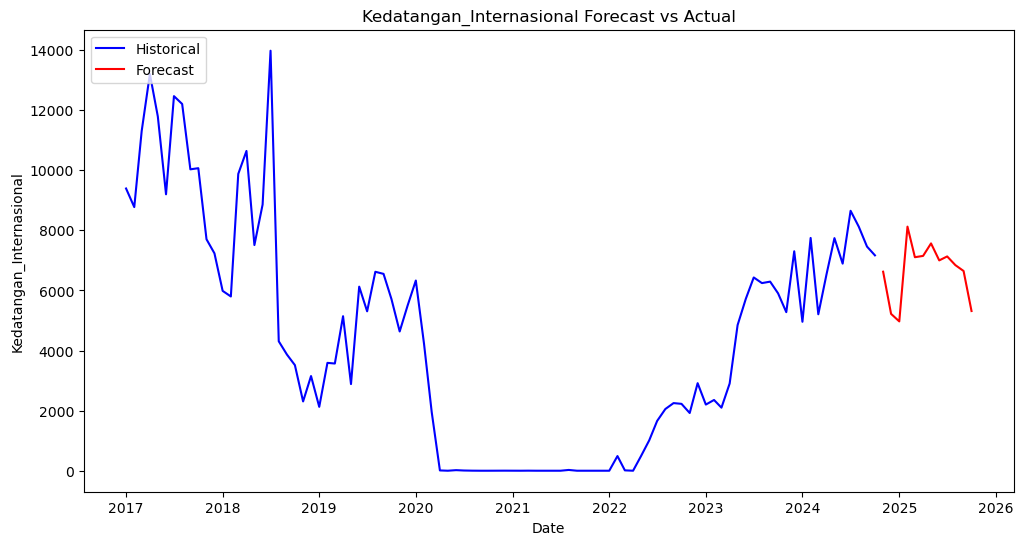

In [ ]:
# Visualize the LSTM forecast
forecast = LSTM_forecast[ARRIVAL].reset_index()
forecast.columns = ['Tanggal', 'Forecast']
combined_data = combine_data(ARRIVAL, forecast, data)
visualize_forecast(ARRIVAL, forecast, data)

### Hybrid (SARIMA-LSTM)

In [700]:
# Generate Hybrid SARIMA-LSTM forecast
HYBRID_forecast = forecast_SARIMA_LSTM(data, ARRIVAL, FORECAST_WINDOW)

# Visualize the Hybrid forecast
forecast = pd.DataFrame({'Tanggal': index_forecast, 'Forecast': HYBRID_forecast()[ARRIVAL]})
combined_data = combine_data(ARRIVAL, forecast, data)
visualize(combined_data, var=['Historical', 'Forecast'], label=ARRIVAL)

Epoch 1/100


/Users/ajhiswara/.local/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1894
Epoch 2/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0228
Epoch 3/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0148
Epoch 4/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0174
Epoch 5/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0163
Epoch 6/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0154
Epoch 7/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0182
Epoch 8/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0111
Epoch 9/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0134
Epoch 10/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0126
Epoch 11/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0113
Epoch 12/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0191
Epoch 13/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0191
Epoch 14/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0182
Epoch 15/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0163
Epoch 16/100
41/

TypeError: forecast_SARIMA_LSTM() missing 3 required positional arguments: 'data', 'arrival_column', and 'forecast_window'